# Analysing cuisines with Yummly

## Introduction

Diets and food habits may vary widely from country to country in terms of ingredients and cooking techniques. Nevertheless, dishes from different regions may share similarities in flavours and tastes. This project aims to help people discover new recipes matching their preferences. Our analysis will be based on Yummly, a platform mainly used in North America containing recipes from different countries. First, we will characterise the taste preferences in a group of countries along with the nutritional intake of an average dish. Second, we will analyse similarities between cuisines in terms of flavours with the purpose of building a recipe recommender that matches one’s taste.

## Research questions
A list of research questions we would like to address during the project:
- What are the most commomly used ingredients?
- What are the most distinctive ingredients?
- How can we represent cuisines as a network of ingredients ?
- How can we cluster cuisine in terms of their recipe components?
- How do cuisines influence each other?

## Imports and Helper functions

The following helper function will be used later in the notebook. You can go through them to have an idea on how things are being displyed/computed.

In [46]:
import pandas as pd
import json
import os
from string import digits
import itertools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import re, pickle
import functools
from IPython.display import HTML
import string
import warnings
from sklearn.feature_extraction import DictVectorizer
import gensim
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"
from graph_helper import community_layout 

warnings.filterwarnings('ignore')

In [100]:
def load_data(lists_folder='data/lists/', recipes_folder='data/recipes/', 
              pickle_file='data/cached.pickle', cache=True):
    ''' Helper function to load and concat data
        Loading data with this function may take time if not using cache. '''
    
    # Load the data from the cached file
    if cache and os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as pf:
            df = pickle.load(pf)
        return df
    
    # Load the basic information on the recipes
    df = None
    for file in os.listdir(lists_folder):
        if 'DS_' in file:
            continue
        file_path = os.path.join(lists_folder, file)
        with open(file_path) as sd:
            data = json.load(sd)['matches']
        cdf = pd.DataFrame(data)
        cdf['cuisine'] = file.split('.')[0].split('_')[-2]
        df = (cdf if df is None else pd.concat([df, cdf]))
    df = df[['flavors', 'id', 'ingredients', 'recipeName', 'cuisine']]
    
    # Load the cooking time and the recipes images from the rest of data
    df_more =  pd.DataFrame(columns = ['id','PrepTime', 'img'])
    for file in os.listdir(recipes_folder):
        if 'DS_' in file:
            continue
        file_path = os.path.join(recipes_folder, file)
        
        with open(file_path) as sd:
            data = json.load(sd)
        cdf = {}
        cdf['id'] = [data['id']]
        if('totalTimeInSeconds' not in data):
            print(data['id'])
        cdf['PrepTime']= data['totalTimeInSeconds']/60.0
        cdf['img'] = data['images'][0]['imageUrlsBySize']['360']
        cdf = pd.DataFrame(data=cdf)
        df_more = pd.concat([df_more, cdf])
    
    # Merge the two data frames in one on the recipe id
    df = pd.merge(df, df_more, on='id')
    
    # Cache the resulting dataframe if caching option if enabled
    if cache:
        with open(pickle_file, 'wb') as pf:
            pickle.dump(df, pf)
    return df


def get_list_ingredients(df):
    ''' Helper function to get the frequency of ingredients from a DataFrame'''
    
    possible_ingredients = {}
    def inc_dict(ing):
        if ing in possible_ingredients.keys():
            possible_ingredients[ing] += 1
            return
        possible_ingredients[ing] = 1
    
    type_ = float
    
    # Compute the frequency of ingredients in a data frame
    df['ingredients'].apply(lambda x: [inc_dict(ing) for ing in x])
    
    # Cast dict to list
    ing_data = np.array([[a[0], a[1]]for a in possible_ingredients.items()])
    ing_data[:,1] = (ing_data[:,1].astype(type_))
    
    label = 'Number of apparition'
    df_ing = pd.DataFrame(data={'Ingredient': ing_data[:, 0], label: ing_data[:, 1].astype(float)})
    return df_ing

def clean_string(s, aslist=False):
    '''Helper function to clean ingredients'''
    remove_digits = str.maketrans('', '', digits)
    remove_punctuation = str.maketrans('', '', string.punctuation)
    remove_whitespace = str.maketrans('', '', string.whitespace)
    
    german_ingr = {'zitrone':'lemon', 'zitronen saft':'lemon juice','zwiebel':'onions', 'öl':'oil'}
    
    # Remove all digits and parenthesis content from ingredients
    tmp = s.translate(remove_punctuation).lower().translate(remove_digits)
    tmp = re.sub(r'\(*\)','',tmp)

    # Remove some stop words
    alist =['low fat', 'reduced fat', 'fat free', 'fatfree', 'nonfat','gluten free', 'free range',
         'reduced sodium', 'salt free','sodium free', 'low sodium', 'sweetened','unsweetened','large','extra large','oz','®','™','oldelpaso','alfredo','knorr'
        ,'hellmannâ','orbestfoodcanolacholesterolfree','€']
    for stra in alist:
        tmp = tmp.replace(stra,'')


    # Normalize ingredient names
    alist = ['chile', 'chili','chilies','chilli','sriracha']

    for pepper in alist:
         if pepper in tmp:
            tmp = 'chili'
            break

    blist = [['flour','flour'],['tumeric','turmeric'],['yoghurt','yogurt'],['yogurt','yogurt'],['sausage','sausage'],['fillet','raw fish'],['mozzarella','mozzarella cheese'],
          ['spinach','spinach']]
    for tup in blist:
        if tup[0] in tmp:
            tmp = tup[1]

    # Translate some ingredient names to english
    if(tmp in german_ingr):
        tmp = german_ingr[tmp]

    # Remove spaces between words that defines an ingredients (e.g. “chicken breast” becomes “chickenbreast”)
    # this step is useful for the tfidf vectorization
    if not aslist:
        tmp = tmp.translate(remove_whitespace)

    return tmp

def get_recipe_cosine_similariy(df, recipe_id, X, lim=10):
    ''' Takes a recipe ID as input and returns its most similar recipes using cosine similarity '''
    index = df.loc[df.id==recipe_id].index[0]
    # Fetch one hot encoding of the recipe and 
    # computes its cosine similarity with the rest of recipes
    one_hot = X[index]
    denominator = np.sqrt(np.square(one_hot).sum())
    cosine_sim = X.dot(one_hot.T)/(np.sqrt(np.square(X).sum(axis=1))*denominator)
    # Sort the most similar recipes and zip them with their ids
    best_id = np.argmax(cosine_sim)
    ids_sorted = np.argsort(-cosine_sim)
    return zip(df.loc[ids_sorted].id.tolist()[1:lim], cosine_sim[ids_sorted][1:lim])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Discalimer: This snippet was taken from the official scikit-learn documentation
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    
def dhtml(html):
    '''Helper function to display html'''
    display(HTML(html))

def display_ul(lis):
    ''' Helper function to display unordered list in HTML'''
    html = '<ul>'
    for el in lis:
        html += '<li>'+str(el)+'</li>'
    html += '</ul>'
    dhtml(html)

def load_doc2vec_model(df):
    ''' Loads/Trains the Doc2Vec model '''
    # Load Doc2Vec model
    doc2vec_filepath = 'doc2vec.model'
    if os.path.exists(doc2vec_filepath):
        print('[Info] Loading existing model from', doc2vec_filepath)
        model = gensim.models.Doc2Vec.load(doc2vec_filepath)
        return model
    print('[Info] Training Doc2Vec model from scratch')
    
    # Constructing the training data for the doc2vec model
    # docLabels contains is the document Ids which is composed of the recipe Id concatenated with its cuisine
    # data contains the recipes ingredients 
    docLabels, data = [], []
    df.apply(lambda x : (docLabels.append([(x.id+' '+x.cuisine)]),data.append(x['text_ingredients'])),axis=1)

    class LabeledLineSentence(object):
        # Class that englobes the Doc2vec training data
        def __init__(self, doc_list, labels_list):
            self.labels_list = labels_list
            self.doc_list = doc_list
            rand_idx = np.random.permutation(list(range(len(self.labels_list))))
            self.labels_list= np.array(self.labels_list)[rand_idx]
            self.doc_list = np.array(self.doc_list)[rand_idx]
        def __iter__(self):
            for idx, doc in enumerate(self.doc_list):
                  yield gensim.models.doc2vec.LabeledSentence(words= doc.split(' '),tags=self.labels_list[idx])

    # Iterator returned over all documents
    it = LabeledLineSentence(data, docLabels)
    model = gensim.models.Doc2Vec(size=2, min_count=5, alpha=0.025, min_alpha=0.025,workers=4,window=8,dm_tag_count = 1)
    model.build_vocab(it)
    
    # Training of model
    for epoch in range(20):
        print('Iteration', epoch+1)
        model.train(it,total_examples=model.corpus_count,epochs = 5)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
        it = LabeledLineSentence(data, docLabels)

    # Saving the created model
    model.save(doc2vec_filepath)
    return model


def get_index_ingredient(ing, vectorizer):
    ''' Helper function to get the index of the ingredient given its name'''
    return np.argmax(vectorizer.transform([{ing:1}])[0])

def get_ing_name(idx, vectorizer):
    ''' Helper function to get the name of the ingredient given its index'''
    return vectorizer.feature_names_[idx]

def get_freq_net_cuisine(df, cuisine, tot_ing, vectorizer):
    '''Computes the pairwise frequency between ingredients in a given cuisine'''
    list_ing = get_list_ingredients(df[df.cuisine==cuisine]).Ingredient
    X_one_hot_cuisine = vectorizer.transform(df[df.cuisine==cuisine].bow.values)
    cuisine_ing_net = np.zeros((tot_ing, tot_ing))
    # Iterate on the list of ingredients and compute their frequency
    for ing_name in list_ing:
        ing_id = get_index_ingredient(ing_name, vectorizer)
        freq_vec = X_one_hot_cuisine[X_one_hot_cuisine[:,ing_id]==1].sum(axis=0)
        # Frequency when it is paired with itself is removed for our convinience
        freq_vec[ing_id] = 0
        cuisine_ing_net[ing_id] = freq_vec
    return cuisine_ing_net

def save_meat_data(df):
    '''Helper function to save meat data for usage in the blog'''
    all_cuisines = df['cuisine'].unique()
    to_json = {}
    for meat in ['salmon', 'tuna', 'chicken','turkey','duck','lamb','beef','pork','bacon']:
        to_json[meat.title()] = {
            'y': [cuisine.title() for cuisine in get_meat_data(meat).sort_values(ascending=False).index.tolist()],
            'x': [prop*100 for prop in get_meat_data(meat).sort_values(ascending=False).tolist()]
        }
    with open('meat-o-meter.json','w') as mo:
        json.dump(to_json, mo)

def save_cluster(df,X_embedded,y_embedded):
    ''' Save the cluster of recipes to use in blog'''
    # Save the data into json for the blog
    y_embedded = df.cuisine.astype('category').cat.categories[y_embedded]
    av_cuisine = np.unique(y_embedded)
    to_json = []
    for acuis in av_cuisine:
        mask = (acuis==y_embedded)
        to_json.append({
            'x': X_embedded[mask,0].tolist(),
            'y': X_embedded[mask,1].tolist(),
            'name': acuis
        })
    with open('recipes_tsne.json', 'w') as cf:
        json.dump(to_json, cf)

        
def save_similarities(df,recipes,X):
    '''Saves the similarities of the recipes in a json file'''
    to_json = {}
    # Iterate over recipes and add them to dict to be saved
    for recipe_id in recipes:
        recipe = df.loc[df.id==recipe_id.split(" ")[0]]
        i, most_similar = 0, []
        for a in get_recipe_cosine_similariy(df, recipe_id, X):
            sim_r = df.loc[df.id == a[0].split(" ")[0]]
            # Check if image exists 
            if len(sim_r['img'].values[0]) > 20:
                most_similar.append({'title':sim_r['recipeName'].values[0],
                                     'image':sim_r['img'].values[0],
                                     'similarity':a[1]
                                    })
                if i >=2:
                    break
                i += 1
        to_json[recipe['recipeName'].values[0]] = {'similars':most_similar, 'img':recipe['img'].values[0]}
    with open('similar-recipes-cosine.json', 'w') as so:
        json.dump(to_json, so)

def save_ingredient_graph(G):
    ''' Saves the graph of ingredients to json '''
    to_json = {'nodes':[], 'edges':[]}
    for n in G.nodes():
        to_json['nodes'].append({
            'id': n,
            'label': n,
            'x':pos[n][0],
            'y':pos[n][1],
            'color':partition[n],
            'size':100
        })
    for u,v in G.edges():
        to_json['edges'].append({
            'id':u.replace(' ','')+v.replace(' ',''),
            'source':u,
            'target':v
        })

    with open('network_ing.json','w') as on:
        json.dump(to_json, on)

## Yummly's Dataset

### Dataset collection

Using the Yummly API, we collect a number of recipes (see `spider.py` for the scrapper code) for 19 cuisines along with their attributes. Our current analysis focuses only on the main course dishes. For each cuisine we take the 1000 first popular recipes since we assume that a cuisine may be characterized by less than a thounsand recipes.

First, we get the list of recipe ids from the Yummly search API (code in `spider.py`), then we collect recipe specific data using the provided ids and Yummly's recipe endpoint. (code in `spider2.py`)

### Dataset description

In what follows, we will load the list of recipes and their corresponding attributes. 

In [20]:
# Load the dataset. 
# For more caching options have a look at the load_data implementation
df = load_data()

# Droping duplicate recipes since one recipe can 
# be part of several cuisines
df = df.drop_duplicates(['id']) 
df = df.reset_index(drop=True)
print('In total, our dataset contains {} recipes'.format(len(df)))

In total, our dataset contains 16567 recipes


In [21]:
list_cuisines = df['cuisine'].unique()
print('In total, we have {} cuisines:'.format(len(list_cuisines)))

# Show number of recipes per cuisine
df_nrecipes = df.rename(columns = {'id': 'Number of recipes'})
df_nrecipes.groupby('cuisine').count().sort_values(by='Number of recipes', ascending=False)[['Number of recipes']]

In total, we have 19 cuisines:


,Number of recipes
cuisine,
american,999
english,998
german,997
chinese,997
greek,997
indian,997
moroccan,994
italian,993
japanese,991


We observe that the number of recipes vary across cuisines. This is mainly due to the fact that Yummly's API returns a random number of recipes per cuisine. However, we assume that even the lowest number of 294 of portuguese recipes can characterize well enough its cuisine.

### Attribute description

In [22]:
sample = df.sample(n=5)
display(sample)

,flavors,id,ingredients,recipeName,cuisine,PrepTime,img
6871,"{'piquant': 0.8333333333333334, 'meaty': 0.333...",Easy-Hawaiian-French-Bread-Pizza-1981530,"[french bread, heavy cream, barbecue sauce, sh...",Easy Hawaiian French Bread Pizza,hawaiian,20.0,https://lh3.googleusercontent.com/xge0VGLf86K9...
4100,"{'piquant': 0.0, 'meaty': 0.16666666666666666,...",French-Lentil-Stew-1878471,"[lentils, spinach, mushrooms, shallots, olive ...",French Lentil Stew,french,45.0,https://lh3.googleusercontent.com/NJrdmxrKVe5d...
3461,"{'piquant': 0.0, 'meaty': 0.8333333333333334, ...",Mini-Beef-Wellingtons-With-Mushrooms-and-Gorgo...,"[filet mignon, salt, pepper, vegetable oil, mu...",Mini Beef Wellingtons With Mushrooms and Gorgo...,english,150.0,null=s360-c
8966,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",Masala-Baked-Indian-Tofu-with-Turmeric-Rice-16...,"[soy sauce, lemon juice, agave nectar, tomato ...",Masala Baked Indian Tofu with Turmeric Rice,indian,40.0,https://lh3.googleusercontent.com/eehD0TL76Ckg...
7911,"{'piquant': 0.8333333333333334, 'meaty': 0.166...",Hungarian-Goulash-Recipezaar_22,"[beef boneless meat stew, butter, onions, garl...",Hungarian Goulash,hungarian,435.0,null=s360-c


Below, we see that our dataset has the following features representing *recipes*:
- **recipeName**: Name of the recipe
- **id**: Unique identifier of the recipe (serves to scrap more details about the recipe)
- **ingredients**
- **cuisine**: cuisine of origin of the recipe
- **flavor**: attributes (Piquant, Meaty, Bitter, Salty, Sour, Sweet)
- **PrepTime**: the cooking time (in minutes)
- **img**: image of the recipe

Here is an example of a recipe:

In [23]:
# Example of one recipe and the attributes that go with it
sample = df[df.flavors != None].sample(n=1).values[0]
dhtml('<h4>Attributes for {}</b>'.format(sample[3]))
display_ul(['<b>{}</b>: {}'.format(df.columns[a], sample[a]) for a in range(len(sample))])

One of the main attributes provided by Yummly is recipes flavours which is defined as the amount of sweetness, bitterness, piquantness, sourness, saltyness and meatiness in a recipe. These attributes can take 6 discrete values uniformly spaced between 0 and 1.

However, as we see below, on average 30% of the recipes do not have flavor attributes. For some cases, approximately half of the ingredients do not have flavor attributes.

In [24]:
print(' Percentage of recipes with missing flavour attributes: {:.3}%'.format(len(df[df.flavors.isnull()])*100.0/len(df)))
df_per_miss_flavors = df.groupby('cuisine').agg(lambda x: len(x[x.flavors.isnull()])*100/len(x) )[['flavors']].sort_values(by='flavors', ascending=False)
df_per_miss_flavors.rename(columns={'flavors': 'Percentage of missing flavors'}, inplace=True)
display(df_per_miss_flavors)

 Percentage of recipes with missing flavour attributes: 30.5%


,Percentage of missing flavors
cuisine,
thai,45.592705
japanese,45.509586
mexican,37.244898
indian,35.506520
italian,35.146022
american,33.233233
hawaiian,31.606218
english,31.462926
french,30.060729


### Dataset cleaning

Our data cleaning procedure mainly focuses on uniformizing ingredients names in our dataset. This was done through multiple steps:
- We removed any punctuation and digit present in the ingredient names
- We strip off any text between parenthesis as we noticed that it usually gives only information about ingredients quantities. Special caracters ('®','™'...) and some brand names were also removed
- We remove some stop words from our ingredient denominations (e.g : 'low fat' ,'skin free'...)
- We apply manual matching to our ingredients as some of them are not written is the same way in all recipes  (e.g: 'chili' is also written as 'chile')
- We noticed that some ingredients are written in german. Hence, we replace some of them by their equivalent in english

In [53]:
# Clean the ingredients
df.ingredients = df.ingredients.apply(lambda x: list(map(lambda y: clean_string(y, aslist=True), x)))

## What are the most commomly used ingredients?

In this section, we explore the most commonly used ingredients across recipes of all cuisines.

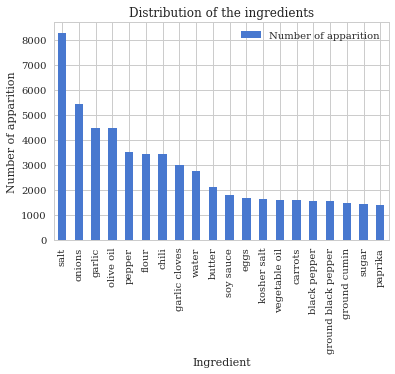

In [54]:
# Get the frequencies of all ingredients
ingredients = get_list_ingredients(df)
freqs = dict([tuple(x) for x in ingredients.values])

# Plot simple bar chart
ax= ingredients.sort_values(by='Number of apparition', ascending=False).head(20).plot(x='Ingredient', y='Number of apparition', kind='bar')
ax.set_title('Distribution of the ingredients')
b=ax.set_ylabel('Number of apparition')

We can clearly see that ingredients with **high prominence** are *salt, garlic, onions and olive oil*. This is expected since they are "basic" ingredients used in almost any main dish across all cuisines.
Here "basic" we mean spices, herbs,oils and vegetables used for flavoring.

Yet, here is another cool representation of the frequency of ingredients:

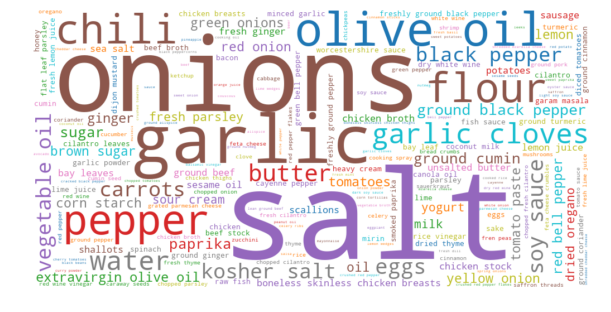

In [55]:
# Plot the word cloud of the most commonly used ingredients
fig = plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white', colormap='tab10', width=1000, height=500).generate_from_frequencies(freqs)
ax=plt.imshow(wc, interpolation='bilinear')
plt.imsave('wc_ing.png', wc)
b=plt.axis('off')

Above, is the wordcloud representation of the ingredients in terms of their frequencies. Each word is scaled proportinal to its ingredient frequency in our dataset.

## Clustering recipes by ingredients

As we are interested in finding similarities between cuisines, clustering recipes using there ingredients would help visualize those similarities and differences. 

We represent a recipe by a one hot encoded vector of its ingredients. To do so, we use **DictVectorizer** provided by scikit learn which establishes a vocabulary of ingredients and encode each recipe in a **5000-dimensional** vector of ingredients.

In [56]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

# Shuffle the dataset for convinience
df = df.sample(frac=1).reset_index(drop=True)

# First we create a bag of words per recipe
# This will be help
df['bow'] = df.ingredients.apply(convert_to_dict)

# One hot encoding of the ingredients
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(df.bow.tolist())
y = df.cuisine.astype('category').cat.codes

Now that we have the one hot ecoding of all recipes, we need a way to project the high dimensional one hot encoding vector to a 2 dimensional space. This can be done using either:
- **PCA**: finds linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. (In this case we use it with the cosine kernel as distance metric)
- **t-SNE**: is based on probability distributions with random walk on neighborhood graphs to find the structure within the data.

PCA's limitation is that it can not find non linear relationship between datapoints. That's one reason why we choose t-SNE as a technique to reduce dimensionsionality of our data.

Besides, we use the we choose **cosine-similarity** as a metric, since for our use, we want to abstract out the magniture of every vector and looks at the “directional similarity” between two vectors.

Following, we filter our dataset for our convinience, and plot the cluster for a subset of cuisines only. The latter are randomly chosen within 19 cusines. Then, we randomly sample approximately 2K recipes to reduce computational expenses. Finally, we compute the square form of cosine similarity of the one hot encoded vectors in our dataset.

In [57]:
list_cuisine_names = df.cuisine.astype('category').cat.categories

# Filter data and keep only n cuisines
n = 7
filtered_cuisines = np.random.permutation(19)[:n]
mask = y.apply(lambda x: x in filtered_cuisines)
X_filtered, y_filtered = X[mask], y[mask]

# Randomly select 2K recipes. Since data is already shuffled randomly then we take the first 2K.
X_filtered_2K = X_filtered[:2000]
y_filtered_2K = y_filtered[:2000]

### PCA: Principal component analysis

In this subsection, we compute the principal components of our dataset using the cosine kernel using the implementation of the PCA algorithm in scikit learn library

In [58]:
from sklearn.decomposition import KernelPCA
X_embedded_pca = KernelPCA(n_components=2, kernel='cosine', n_jobs=2).fit_transform(X_filtered_2K)

Next, we plot the embedded results in a 2-dimensional graph:

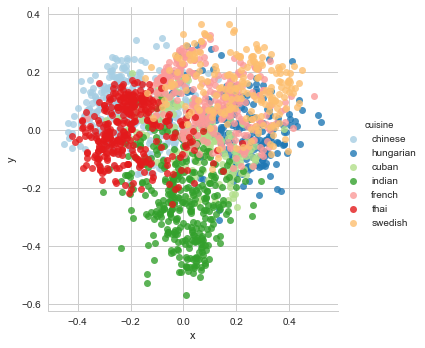

In [59]:
# Plotting the clusters
plotting_df = pd.DataFrame(data=X_embedded_pca[:,:2], columns=['x','y'])
plotting_df['cuisine']= list_cuisine_names[y_filtered_2K].tolist()
sns.set(style="whitegrid", palette="muted")
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
sns.lmplot("x", "y", data=plotting_df, palette=palette, hue='cuisine', fit_reg=False)

We observe the presence of some clusters as the japanese and the thai cuisines overlap and the italian and spanish cuisines overlap as well. PCA with cosine kernel does fiairly well for 7 cuisine but as the number of cuisines increases, it will be impossible to distinguish clusters.
As we will see next, t-SNE will provide a much better way to reduce the dimensionality of our data.

### t-SNE: t-distributed Stochastic Neighbor Embedding

In this subsection, we compute the t-distributed Stochastic Neighbor Embedding of our one hot encoded vectors using the cosine similarity with implementation of the t-SNE algorithm provided by the scikit learn library.

In [60]:
# Compute the cosine similarity square form for each vector and run t-SNE
X_to_reduce = squareform(pdist(X_filtered_2K, metric='cosine'))
X_embedded_tsne = TSNE(metric='precomputed').fit_transform(X_to_reduce)

Next, we plot the embedded results in a 2-dimensional graph:

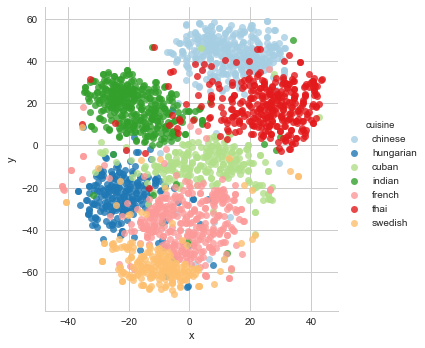

In [61]:
# Plotting the clusters on with t-sne projections
plotting_df = pd.DataFrame(data=X_embedded_tsne[:,:2], columns=['x','y'])
plotting_df['cuisine']= list_cuisine_names[y_filtered_2K].tolist()

sns.set(style="whitegrid", palette="muted")
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
sns.lmplot("x", "y", data=plotting_df, palette=palette, hue='cuisine', fit_reg=False)

# Save the data in file to show it in blog
# save_cluster(df, X_embedded_tsne, y_filtered_2K)

As a first observation, tSNE projection is much clearer than PCA: cluster are more visible and we have the same high level insights as with KPCA.(e.g. Japanese and Thai cuisines are relatively close in both graph)

An interesting insight is the proximity of cuisines from close geographical regions or shared cultur(e.g. Indian and Thai -- Irish and English). The reason behind this is the similarity of used ingredients in recipes that can be explained by history and availability of ingredients in some regions compared to others.

## How do cuisines influence each other?

In this section, we train linear classifer and analyse its performance using train and test splits, then we extract the most "confused" cuisines and finally establish some hypothesis that may explain this confusion.

We chose Logistic Regression as a classifier since it is a simple linear classifier for which we can analyse the weights and deduce the importance of ingredients in the classification process.

In [62]:
# Creating train and test splits for the basic classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(multi_class= 'multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

print('Test accuracy:', clf.score(X_test,y_test))
print('Train accuracy:', clf.score(X_train,y_train))

Test accuracy: 0.836320409656
Train accuracy: 0.972700243265


As we see above, our classifer is doing a pretty good joob in discriminating between cuisine even though it fails in some cases:

Normalized confusion matrix


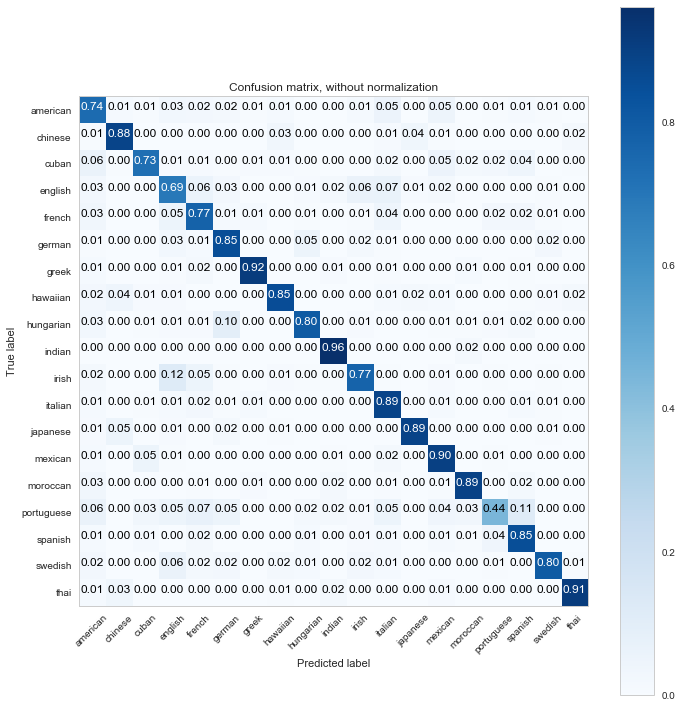

In [63]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=df.cuisine.astype('category').cat.categories.tolist(),
                      title='Confusion matrix, without normalization', normalize=True)

Below, we use a Sankey diagram to better represent the confusions of our classifer:

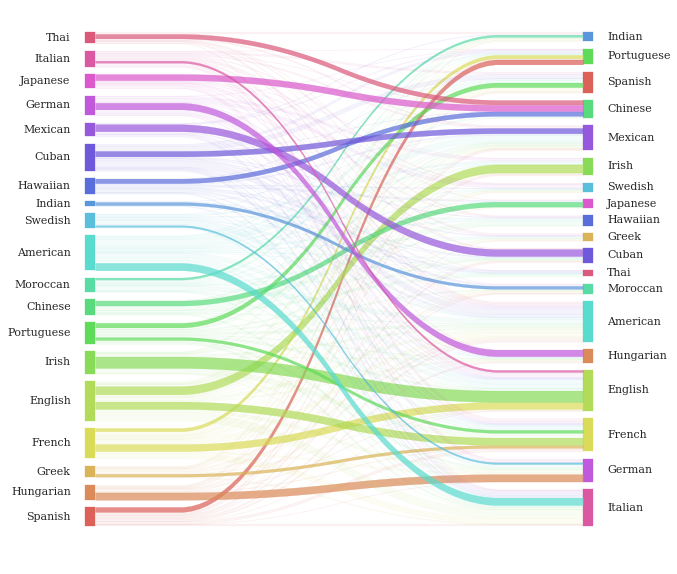

In [64]:
import sankey

names_cuisines= df.cuisine.astype('category').cat.categories.tolist()
df_cnf_norm = pd.DataFrame(data=cnf_matrix, index=names_cuisines, columns=names_cuisines)
df_cnf_norm = df_cnf_norm / df_cnf_norm.sum(axis=1)

# colorDict =  {'apple':'#f71b1b','blueberry':'#1b7ef7','banana':'#f3f71b','lime':'#12e23f','orange':'#f78c1b'}
mask = ~(y_test == y_pred)
y_test_labeled= df.cuisine.astype('category').cat.categories[y_test[mask]].tolist()
y_pred_labeled= df.cuisine.astype('category').cat.categories[y_pred[mask]].tolist()

sankey.sankey(y_test_labeled, y_pred_labeled, aspect=20, fontsize=11, cnf_matrix=df_cnf_norm)
plt.gcf().set_size_inches(10,10)
# plt.savefig('fruits.png',bbox_inches='tight',dpi=150)

On both sides, all the cuisines are listed. We link the cuisines that show high confusion rate and set the thickness of each line to be proportional to it. Then, we only keep the most relevant ones (i.e. showing the most confused cuisines)
*Note that the size of the small bar next to the cuisine name is not relevant for analysing the graph.*

As a first observation, we can point out that most of the cuisines confused are geographically close (Portuguese and Spanish or Japanese and Chinese). Moreover, we see that Irish recipes is highly confused with English dishes but not the other way around. Indeed, our confusion matrix is not symetric since the influence of cuisines on each other is not symetric.


## What are the most distinctive ingredients?

In this section, we explore the iconic ingredients for each cuisine using our Logistic Regression model. The most iconic ingredients are defined to be the ones which differentiate the most a cuisine from others. Subsequently, we use our logistic regression model and rank the ingredients relatively to their weights.

In [67]:
# First we train LR on the whole dataset of recipes
clf = LogisticRegression(multi_class= 'multinomial', solver='lbfgs')
clf = clf.fit(X, y)

# Display a sample of most distinctive ingredients
df_dist_ing = None
sample_cuisines = [1,9,14,4]
for i in sample_cuisines:
    top_features = [vectorizer.feature_names_[ing_id] for ing_id in np.argsort(-clf.coef_[i])[:20]]
    dist_ing_df_i = pd.DataFrame(data= {'Cuisine': df.cuisine.astype('category').cat.categories[i],
                                     'Most distinctive ingredients': top_features[:4]})
    df_dist_ing = dist_ing_df_i if df_dist_ing is None else pd.concat([df_dist_ing, dist_ing_df_i])
display(df_dist_ing.set_index(['Cuisine', 'Most distinctive ingredients']))
dhtml('<i>For a better visualization, refer to our blog.</i>')

Empty DataFrame
Columns: []
Index: [(chinese, chinese fivespice powder), (chinese, soy sauce), (chinese, hoisin sauce), (chinese, szechwan peppercorns), (indian, garam masala), (indian, curry powder), (indian, yogurt), (indian, ground turmeric), (moroccan, harissa), (moroccan, couscous), (moroccan, ground cinnamon), (moroccan, preserved lemon), (french, herbes de provence), (french, gruyere cheese), (french, swiss cheese), (french, shredded swiss cheese)]

Although the above list shows the distinctive ingredients, typical cuisine dishes are usually characterized by a combination of ingredients.

## How can we represent cuisines as a network of ingredients ?

In this section, we analyse combination of ingredients in cuisine recipes for a better description of a cuisine. Our approach consists in extracting the frequently used combination of ingredients that are typical to each country.

First, we compute the pairwise appearance frequency between all ingredients in our dataset which will generate a N by N matrix (denoted by A) of frequencies(N is the number of ingredients). We then do the same operation for every cuisine.

In [68]:
# Building the first matrix of pairwise frequencies (matrix A in explanation )
ing_net = np.zeros((X.shape[1], X.shape[1]))
for ing_id in range(X.shape[1]):
    freq_vec = X[X[:,ing_id]==1].sum(axis=0)
    freq_vec[ing_id] = 0
    ing_net[ing_id] = freq_vec

Now that we got a pairwise frequency matrix of ingredients for each cuisine, we discount each one of them using coefficient of matrix A.

In [69]:
# Listing the cuisine to be displayed in the graph
cuisines = ['french', 'italian', 'japanese', 'chinese', 'english', 'mexican', 'indian', 'irish']
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

# Build the graph where each node is an ingredient
# And edges link ingredients frequently used togheter in recipes
G = nx.Graph()
j = 0
for cuisine in cuisines:
    # Get the pairwise frequency matrix and discount it
    cuisine_ing_net = get_freq_net_cuisine(df, cuisine, X.shape[1], vectorizer)
    cuisine_net_discounted = cuisine_ing_net/(ing_net+1)
    i=0 # Add associated edges and nodes to the graph
    for raveled_id in np.argsort(-cuisine_net_discounted.reshape(-1)):
        a, b = np.unravel_index(raveled_id, cuisine_net_discounted.shape)
        # Take only a small number of ingredient for visual convinience
        if i > 10:
            break
        u, v = get_ing_name(a, vectorizer), get_ing_name(b, vectorizer)
        G.add_edge(u, v, cuisine=j, color=palette[j], weight=1, width=cuisine_net_discounted[a,b])
        i += 1
        
    j += 1

Next we use networkx to draw the ingredient network:

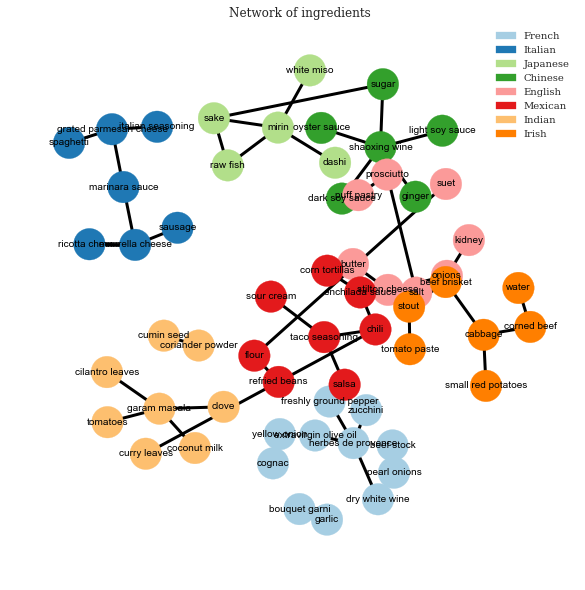

In [92]:
# Build a dictionary to associate each ingredient 
# to a cuisine where it appears the most
colors_nodes = []
partition = {}
for u in G.nodes():
    best_color={}
    for v in G[u]:
        best_color[G[u][v]['color']] = 1 if not G[u][v]['color'] in best_color else best_color[G[u][v]['color']]+1
    partition[u] = sorted(best_color.items(), key=lambda x: x[1])[-1][0]
    
# Compute the x,y coordinates of the nodes
pos = community_layout(G, partition)

# Plot the graph (nodes and edges)
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Plot the legend
patches = [mpatches.Patch(color=co, label=cu.title()) for co,cu in zip(palette,cuisines)]
plt.legend(handles=patches)
plt.title('Network of ingredients')
plt.axis('off')

# Save the graph for the blog
save_ingredient_graph(G)

As we can see in many cuisines, ingredients orbit around a central ingredient: `Fish sauce` for thai food, `Enchilada Sauce` for mexican food or `Gram masala` for indian food. Moreover, Asian cuisines like Chinese and Japanese share ingredients many ingredients as Italian and French do.

## Who are the biggest consumer of meats?

In this section, we analyse the proportion of meats in cuisines since we assume that meat is a major components of a recipe.

First, we clean the ingredient names for our convinience. Then we will explore how cuisines consumes different type of meats. In our case, we will restrict the types of meat to `'salmon', 'tuna', 'chicken','turkey','duck','lamb','beef','pork','bacon'` for their worldwide popularity.

In [93]:
# Clean the ingredients
df['text_ingredients'] = df.ingredients.apply(lambda l_ingredients : functools.reduce(lambda acc,x : acc +' ' +x,map(lambda ingred: clean_string(ingred),l_ingredients)))
def get_meat_data(meat):
    return df[['cuisine','text_ingredients']].groupby(by='cuisine').agg(lambda x: len(x[x.apply(lambda a: meat in a)])/len(x))['text_ingredients'].fillna(0)

#Save data for usage in blog
save_meat_data(df)

Then we take as an example the duck consumption.

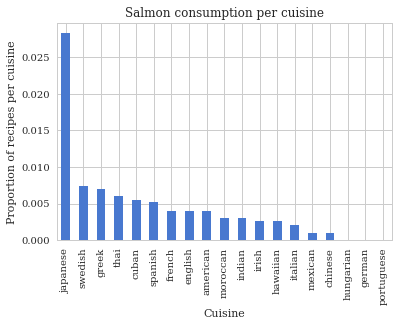

In [94]:
ax = get_meat_data('salmon').sort_values(ascending=False).plot(kind='bar')
ax.set_ylabel('Proportion of recipes per cuisine')
ax.set_xlabel('Cuisine')
b=ax.set_title('Salmon consumption per cuisine')

From our data, Japan is the first consumer of salmon. Indeed, japanese cuisine is famous for consuming a lot of sea food.

See our blog for an interactive version of the Meat'O'Meter.

Text(0.5,1,'Chicken consumption per cuisine')

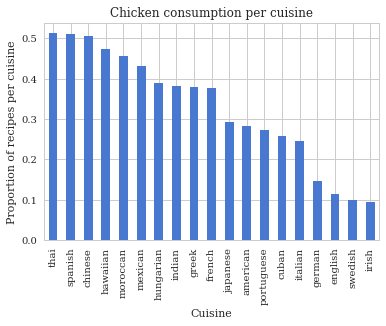

In [95]:
#TODO check
ax = get_meat_data('chicken').sort_values(ascending=False).plot(kind='bar')
ax.set_ylabel('Proportion of recipes per cuisine')
ax.set_xlabel('Cuisine')
ax.set_title('Chicken consumption per cuisine')

From plotting various types of meat, we see different distributions with the following being noticeable:
- Indian and Mexican cuisines use poultry much more than red meats.
- Asian, more specificcaly, Japanese recipes contain more seafood compared to other cuisines.
- Interestingly, some cuisines do not have recipes containing some types of meat.

The results can be explained by the the fact that cuisines mostly use ressources available in their specific region (example of high fish appearance in Japanese recipes which is an island). Another reason is culture and believes, some countries have specific religions or practices forbidding eating specific types of meats (e.g: Beef in India - Pork and bacon Morocco)

## What about the cooking time?

In this section, we explore the similarities between cuisines in terms of cooking time.

First, we explore the distribution of cooking time in our dataset:

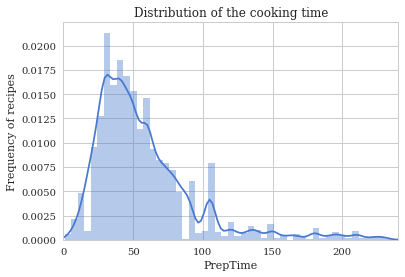

In [96]:
# Plot the distribution of the cooking time
threshold=240
ax = sns.distplot(df.loc[df.PrepTime < threshold]['PrepTime'], bins=50)
ax.set_ylabel('Frequency of recipes')
ax.set_title('Distribution of the cooking time')
a = ax.set_xlim((0,threshold))

In [97]:
# 0.9 quantile of cooking time series
print('90% of recipes have a cooking time less than {} min'.format(df['PrepTime'].quantile(0.9)))

90% of recipes have a cooking time less than 140.0 min


Since 90% of recipes can be prepared in less than 140 minutes, we decide to base our analysis on that specific range ([0,140]).

One way to compare the cooking time distributions of different countries is through comparing their cumulative distributions:

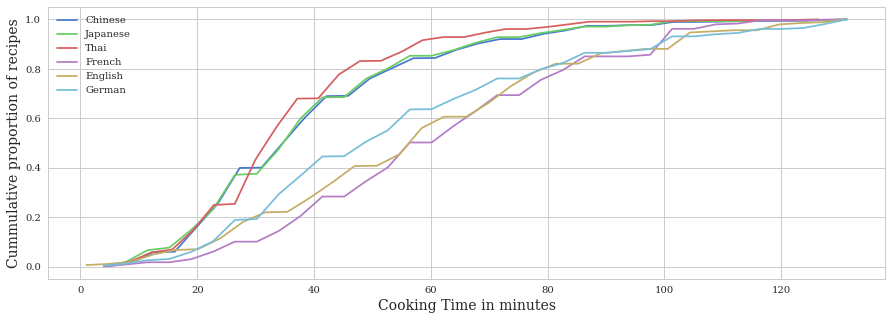

In [98]:
# Plot the cooking time's cumulative distribution for a sample of european and asian countries.
plt.figure(figsize=(15,5))
cuisine_sample = df.cuisine.astype('category').cat.categories
cuisine_sample = ['chinese', 'japanese', 'thai', 'french', 'english', 'german']

# For each cuisine compute the cumulative distribution of the cooking time and plot it.
for cuisine in cuisine_sample:
    prep_times = df.loc[df.cuisine==cuisine, 'PrepTime'].values
    prep_times = prep_times[prep_times < 140]
    values, base = np.histogram(prep_times, bins=35)
    # Compute the cumulative distribution
    cumulative = np.cumsum(values)
    cumulative = cumulative/cumulative.max()
    ax = plt.plot(base[:-1], cumulative)
plt.ylabel("Cummulative proportion of recipes", fontsize=14)
plt.xlabel("Cooking Time in minutes", fontsize=14)
plt.legend([c_title.title() for c_title in cuisine_sample])
plt.grid(True)

The distribution of the Asian cuisines (chinese,japanese and thai) are quite similar to each other but different from the European cuisines(english, french and german). Asian recipes are less time demanding to prepare than the European ones. This can be explained by the eating habits in Asia in which meals are composed of few dishes each taking less time to cook than preparing a one-dish meal.

## Recommending similar recipes

After the previous analysis, we saw how cuisines are similar to each other in different aspects. A good problem to tackle would be to build a recommendation system for recipes. For a comparison purpose, we approach this task using two different methodoligies. This will help us estimate their performance since there is no clear metric associated to the task.

** Cosine similarity with Doc2Vec vectors embedding** 

Doc2Vec creates a vectorized representation of a document by taking into consideration their contexts. Our intuition is that it will help capture deeper relations between ingredients given the context in which they are used. 

Doc2Vec takes as input recipe ID along with its associated cuisine and its ingredients and returns a vector representation of the recipes. The length of the output vector is given as an input parameter. By specifing a output vector length which is significantly smaller than the one hot encoding vectors length. We force the algorithm to compress the recipes informations and to learn nore complex relationships between them. Therefore, comparing 2 recipes vectors by cosine similarity using the Doc2Vec vector will give us more meaninful information than the simple comparision of the one hot encoded vectors.

Now let's give a brief explanation on how the Doc2Vec algorithm works. The algorithm builds a neural network to predict a word based on its context. The size of the context is defined beforehand and is called the window size. For example, if we choose a window size of 2, every word's context will be defined based on the 2 words that neighbor it.

For a more detailed explaination,refer to the original paper (https://arxiv.org/pdf/1405.4053.pdf) or to this blog (https://towardsdatascience.com/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

In [101]:
#  Load Doc2Vec model
doc2vec_model = load_doc2vec_model(df)
# Find similar recipes
recipe_id = 'Spaghetti-alla-Carbonara-902641 italian'
html = '<h4>Most similar recipes to {} according to Doc2Vec</h4><ul>'.format(recipe_id)
for sim_rec in doc2vec_model.docvecs.most_similar(recipe_id):
    html += '<li><b>{}</b> ({:.3}%)</li>'.format(sim_rec[0], sim_rec[1]*100)
html += '</ul>'
dhtml(html)

[Info] Loading existing model from doc2vec.model


** Cosine similarity **

The recipe can be compared by summing the one hot encoding vectors of their ingredients and computing the cosine similarity between them. Hence,with this method, the problem of answering the question `How two recipes are close to each other ?` reduces to evaluating the cosine similarity of their vector representation, A value close to 1 indicate a high similarity between the two recipes , whereas a value close to 0 indicate no similarity between the two recipes.

In [102]:
# Most similar recipes according to cosine metric
recipe_id = 'Spaghetti-alla-Carbonara-902641'
html = '<h4>Most similar recipes to {} according to cosine similarity</h4><ul>'.format(recipe_id)
for sim_rec in get_recipe_cosine_similariy(df, recipe_id, X):
    html += '<li><b>{}</b> ({:.4}%)</li>'.format(sim_rec[0], sim_rec[1]*100)
html += '</ul>'
dhtml(html)

As we can see, the Doc2Vec approach does not perform well compared to the latter one. The reason behind it is that Doc2Vec uses the misleading representation of recipe as a document where the order of the words (in this case, the ingredient names) matter which is not the case. Thus, if the size of the aformentioned window is not big enough, Doc2Vec would be limited in infering the context of ingredients which may lead to poor results.

Therefore, cosine similarity with one hot encoded vectors would be more suited for this task, since it computes the dot product between ingredients which preserves the relationship between them. For instance, if we are looking for similar recipes for spaghetti with bolognaise sauce, the latter metric will associate higher weights to recipes having both these ingredients. 

One limitation of the cosine similarity is the low confidence level of the resulting suggestions. As we can see above The first suggestion has only 57% similarity with the concerned recipe.

In [104]:
# Save most similar recipes for a bunch of them to use in blog
recipes =  df.sample(20)
recipes = recipes.loc[recipes.img.apply(lambda x: len(x) > 20)]
recipes_doc2vec = recipes.apply(lambda x: x.id+' '+x.cuisine, axis=1).tolist()
recipes_cosine = recipes.id.tolist()
save_similarities(df, recipes_cosine, X)

## Fun Facts

In this section we present some fun fact our different countries eating habits.<br/>
Let's start by finding the cuisines that uses the most avocado  (alami)

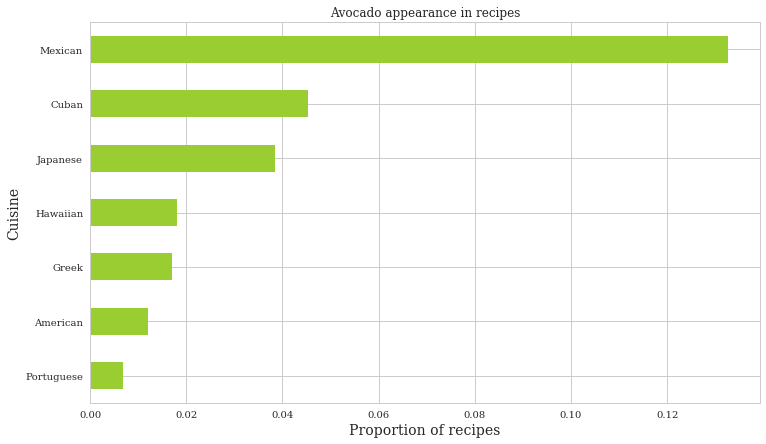

In [105]:
plt.figure(figsize=(12,7))
ax = get_meat_data('avocado').sort_values(ascending=False)[:7].plot(kind='barh', color='yellowgreen')
ax.set_title('Avocado appearance in recipes')
ax.set_xlabel('Proportion of recipes', fontsize=14)
ax.set_ylabel('Cuisine', fontsize=14)
plt.gca().invert_yaxis()
b=ax.set_yticklabels(labels=[b.get_text().title() for b in ax.get_yticklabels()])

As we can see mexican cuisine is the one that uses the most avocados. 

Let's now check if american cuisines is only about burgers

In [106]:
american_recipes = df.loc[df.cuisine == 'american']

def get_recipe_with_title(df, needle):
    return (df[df.recipeName.apply(lambda x: needle in x.lower()) |
               df.text_ingredients.apply(lambda x: needle in x.lower())])

ratio_burgers=len(get_recipe_with_title(american_recipes, 'burger'))/len(american_recipes)
print('{:.4}% of American recipes contain the word burger'.format(ratio_burgers*100,'%'))

6.507% of American recipes contain the word burger


According to Yummly, less than 7% of american recipes are about burgers. Also, none of the most distinctive ingredients of the US is used to prepare it. Thus, we deduce that american eating burgers remains just a stereotype.

## Conclusion

From this project, we answered various questions by analysing our dataset. Indeed, we establish similarities between cuisines, their mutual influences and finally characterized each with a set of distinctive components. To do so, we needed to carefully explore and clean the data during which we faced challenges such as correcting the ingredients names and dealing with duplicate values. Besides, we explored various techniques, some of which revealed good results and led to meaningful insights.